# Preliminaries

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25,
          'animation.embed_limit': 2**128}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy import fft
from scipy.interpolate import griddata

# to save plots as files and download them
#from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

Code adapted from footnotes in the [landmark](https://physics.aps.org/articles/v6/15) paper by Zabusky and Kruskal in [_Physical Review Letters_](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.15.240).

Notes (extra):
*   http://www.scholarpedia.org/article/Soliton (The code provided therein, based on Ch. 10 of [Trefethen's book](https://epubs.siam.org/doi/book/10.1137/1.9780898719598) is more efficient, but I did not implement it here; see also Ch. 7 in [J. Yang's book](https://epubs.siam.org/doi/book/10.1137/1.9780898719680) for more on numerical methods for nonlinear waves, and [this neat code](https://scipy-cookbook.readthedocs.io/items/KdV.html) using pseudospectral discretization in space and, then, the method of lines, as below.)

# The KdV equation

Consider
$$ u_t + uu_x + \delta^2 u_{xxx} = 0 $$
subject to periodic boundary conditions (BCs):
$$ u(x_\mathrm{min},t) = u(x_\mathrm{max},t) $$
on the spatial interval $x_\mathrm{min}\le x \le x_\mathrm{max}$.

In [2]:
# dispersion parameter
delta = 0.022

# spatial interval
xmin = -3
xmax = 3

# number of grid points in discretization
N = 500
# grid spacing
h = (xmax-xmin)/N

# the grid
xj = np.linspace(xmin,xmax,num=N,endpoint=False)

## The initial condition

In [ ]:
# the soliton
def soli(x,t,x0,u0,uinf,delt):
  ddelt = delt/np.sqrt((u0 - uinf)/12)
  v0 = uinf + (u0 - uinf)/3
  u = uinf + (u0 - uinf)*1/np.cosh((x-v0*t-x0)/ddelt)**2
  return u

In [ ]:
# set an initial condition
# move the one you want to the bottom or comment/uncomment

# orignal ZK65
#uic = np.cos(np.pi*xj)

# a Gaussian
uic = np.exp(-20*xj**2)

# two superimposed solitons
#uic = soli(xj,0,0.5,2,0,delta) + soli(xj,0,1.5,1,0,delta)

Whichever initial condition we chose, let's plot it.

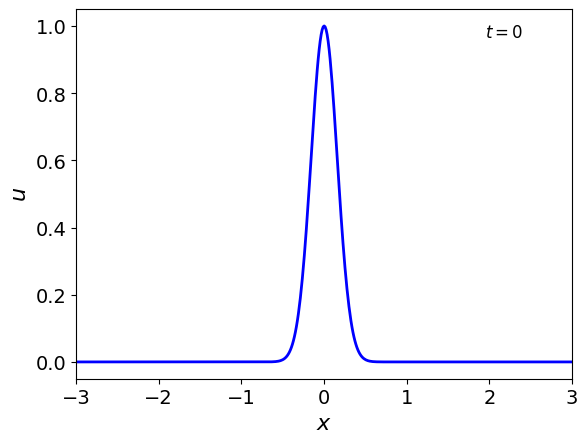

In [ ]:
fig, ax = plt.subplots()
ax.plot(xj, uic, color='blue', linewidth=2)
#ax.set_ylim(-1.1,2.1)
ax.set_ylabel('$u$')
ax.set_xlim(xmin,xmax)
ax.set_xlabel('$x$')
ax.text(0.825, 0.925, f'$t=0$', size='large', transform=ax.transAxes);

# Numerical solution

In footnote 6, Zabusky and Kruskal provide their space-time discretization of the KdV partial differential equation. Below, we implement the same spatial discretization, but leave the problem _semi-discrete_ and use `solve_ivp` from SciPy to advance the solution in time.

So, the semi-discrete problem (this approach is called the [method of lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html)) we wish to solve is
$$ \dot{u}_j = -\underbrace{\left(\frac{u_{j+1} + u_j + u_{j-1}}{3}\right)}_{\approx u}\underbrace{\left(\frac{u_{j+1} - u_{j-1}}{2h}\right)}_{\approx u_x} - \delta^2\underbrace{\left(\frac{u_{j+2} - 2u_{j+1} + 2u_{j-1} - u_{j-2}}{2h^3}\right)}_{\approx u_{xxx}},\quad j=0,\dots,N-1 $$
so that $u_j(t) \approx u(x_j,t)$, where $x_j = x_\mathrm{min}+jh$ with $h=(x_\mathrm{max}-x_\mathrm{min})/N$ being the grid spacing.

Here, $j=N$ is not included because, by periodic BCs, $u_0=u_{N}$ are the _same_ gridpoint.

In [ ]:
# ODE system right-hand side
def zk65(t,u):
  F = np.empty(N)

  # boundary nodes require special care to enforce perdiodic BCs
  F[0] = -(u[1] + u[0] + u[N-1])/3 * (u[1] - u[N-1])/(2*h) \
         -delta**2*(u[2] - 2*u[1] + 2*u[N-1] - u[N-2])/(2*h**3)
  F[1] = -(u[2] + u[1] + u[0])/3 * (u[2] - u[0])/(2*h) \
         -delta**2*(u[3] - 2*u[2] + 2*u[0] - u[N-1])/(2*h**3)
  F[N-2] = -(u[N-1] + u[N-2] + u[N-3])/3 * (u[N-1] - u[N-3])/(2*h) \
             -delta**2*(u[0] - 2*u[N-1] + 2*u[N-3] - u[N-4])/(2*h**3)
  F[N-1] = -(u[0] + u[N-1] + u[N-2])/3 * (u[0] - u[N-2])/(2*h) \
             -delta**2*(u[1] - 2*u[0] + 2*u[N-2] - u[N-3])/(2*h**3)

  # interior nodes, per the formula
  for j in range(2,N-2):
    F[j] = -(u[j+1] + u[j] + u[j-1])/3 * (u[j+1] - u[j-1])/(2*h) \
           -delta**2*(u[j+2] - 2*u[j+1] + 2*u[j-1] - u[j-2])/(2*h**3)

  return F

In [ ]:
# simulation parameters
tmax = 2

# try: test different tolerances for the integrator, changing reltol
reltol = 1e-5

We use SciPy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to numerically integrate the system of $N$ ODEs forward in time using the '[Radau](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Radau_methods)' method for [stiff](https://en.wikipedia.org/wiki/Stiff_equation) problems, with time-step adaptation and error control.

In [ ]:
# solve the semi-discrete KdV
sol = solve_ivp(fun=zk65,
                t_span=[0,tmax], y0=uic,
                method='Radau', rtol=reltol, dense_output=True)

# Results and visualization

## Static plot

First, just a quick static plot of the solution at the final time.

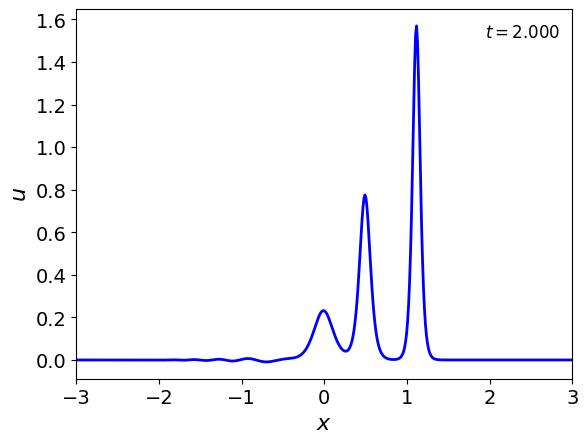

In [ ]:
tplot = tmax
uj = sol.sol(tplot)

fig, ax = plt.subplots()
ax.plot(xj, uj, linewidth=2, color='blue')
ax.set_ylabel('$u$')
#ax.set_ylim(-1,3)
ax.set_xlabel('$x$')
ax.set_xlim(xmin,xmax)
ax.text(0.825, 0.925, f'$t={tplot:.3f}$', size='large', transform=ax.transAxes);

## Animation

Next, we visualize our results using our snazzy animation tools.

In [ ]:
# define how to sample the solution in time
tnum = 250
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [ ]:
# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u$')
ax.set_xlabel('$x$')
ax.set_xlim(xmin,xmax)
ax.set_ylim(-0.07,uj.max()*1.1) # to look nice, similar to plot above
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(xj, 0*xj, color='blue', linewidth=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol.sol(it*dt)
  line.set_data(xj, uj)
  ttl.set_text(f'$t={it*dt:.3f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

## Space-time plot

In [ ]:
# define how to sample the solution in time
tnum = 250
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

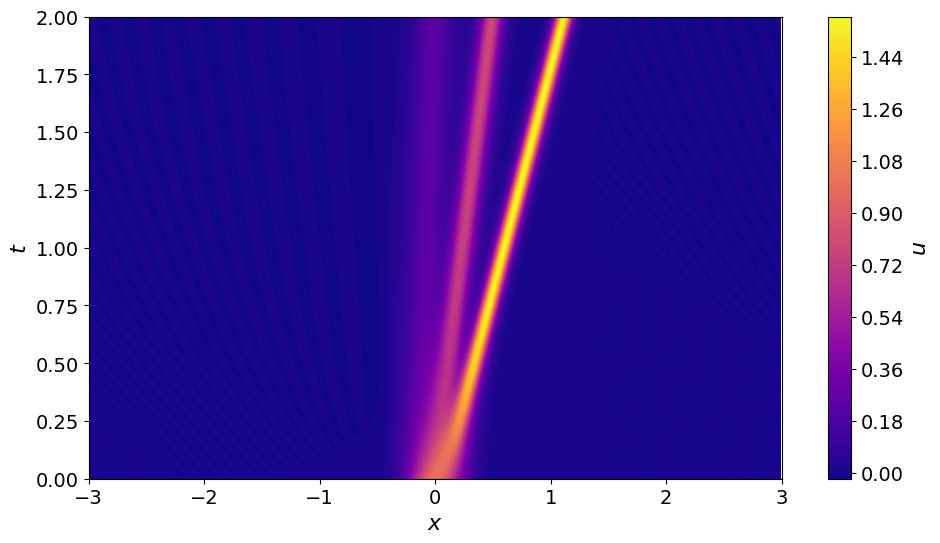

In [ ]:
# make a matrix of space-time values u(x,t)
ujp = np.empty((tnum,N))
for it in range(0,tnum):
  ujp[it,:] = sol.sol(it*dt)

# make cool plot
# could also try 'diverging' colormaps like 'RdGy' or 'coolwarm'
# if u(x,t) is both positive and negative in the simulation
fig, ax = plt.subplots(figsize=(12, 6))
plt.contourf(xj, tspan, ujp, 100, cmap='plasma')
plt.colorbar(label='$u$')
ax.set_ylim(0,tmax)
ax.set_ylabel('$t$')
ax.set_xlim(xmin,xmax)
ax.set_xlabel('$x$')
ax.set_aspect(2/1)

# Conservation properties of the solution

The "momentum" should be more-or-less exactly conserved (for any $t>0$):
$$ \sum_{j=0}^{N-1} u_j (t) = \sum_{j=0}^{N-1} u_j (0) = const.,$$
and the "energy" _almost_ conserved (for any $t>0$):
$$ \sum_{j=0}^{N-1} \frac{1}{2}[u_j (t)]^2 \approx \sum_{j=0}^{N-1} \frac{1}{2}[u_j (0)]^2 = const. $$
(Again, $j=N$ is not included because it is the same gridpoint as $j=0$ for periodic BCs.)

Verifying these conservation properties  will give us confidence in our numerical solutions.

In [ ]:
# define how to sample the solution in time
tnum = N
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [ ]:
# compute the momentum and energy as functions of t
momentum = np.empty(tnum)
energy = np.empty(tnum)
for it in range(0,tnum):
  uj = sol.sol(it*dt)
  momentum[it] = np.sum(uj)
  energy[it] = np.sum(0.5*uj**2)

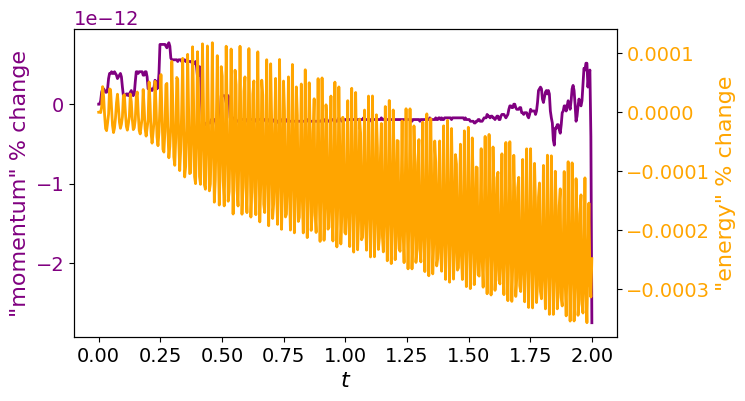

In [ ]:
fig, ax1 = plt.subplots(figsize=(7,4))

# momentum on the left axis
ax1.plot(tspan, (momentum-momentum[0])/momentum[0]*100, lw=2, color='purple')
ax1.set_ylabel('"momentum" % change', color='purple')
ax1.set_xlabel('$t$')
ax1.tick_params(axis='y', labelcolor='purple')

# energy on the right axis
ax2 = ax1.twinx()
ax2.plot(tspan, (energy-energy[0])/energy[0]*100, color='orange', lw=2)
ax2.set_ylabel('"energy" % change', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')